# Seasonal preferences
Understanding seasonal trends and using this information to generate better recommendations

#### Data preparation

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from lightgbm.sklearn import LGBMRanker
from experiment_template import *
import os as os

In [31]:
path = "../Data/"
print(os.getcwd())
transactions_train = pd.read_parquet(path + 'transactions_train.parquet')
customers = pd.read_parquet(path + 'customers.parquet')
articles = pd.read_parquet(path + 'articles.parquet')
sample_submission = pd.read_csv(path + 'sample_submission.csv')

C:\Users\Arno\Documents\GitHub\ai-project-23-24\ArnoDeKeersmaeker\Research


In [32]:
transactions_train.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week
25784,2018-09-20,1728846800780188,519773001,0.028458,2,0
25785,2018-09-20,1728846800780188,578472001,0.032525,2,0
5389,2018-09-20,2076973761519164,661795002,0.167797,2,0
5390,2018-09-20,2076973761519164,684080003,0.101678,2,0
47429,2018-09-20,2918879973994241,662980001,0.033881,1,0


In [33]:
# Define periods here
seasons = {
    "Summer": [6,7,8],
    "Autumn": [9,10,11],
    "Winter": [12,1,2],
    "Spring": [3,4,5]
}
# Define the name of the current period (end of September)
current_season = "Autumn"

assert current_season in seasons.keys() # Current period exists
assert set(month_nr for month_nrs in seasons.values() for month_nr in month_nrs) == set(range(1,13)) # All months are in a period
inverted = {month_nr: period for period, month_nrs in seasons.items() for month_nr in month_nrs} # For more efficient lookup

def get_season(month_nr):
    assert month_nr in range(1,13)
    return inverted[month_nr]

transactions_train["t_dat"] = pd.to_datetime(transactions_train["t_dat"])
transactions_train["season"] = transactions_train["t_dat"].dt.month.apply(get_season)
transactions_articles = pd.merge(transactions_train, articles, on="article_id")

#### Exploring season related things

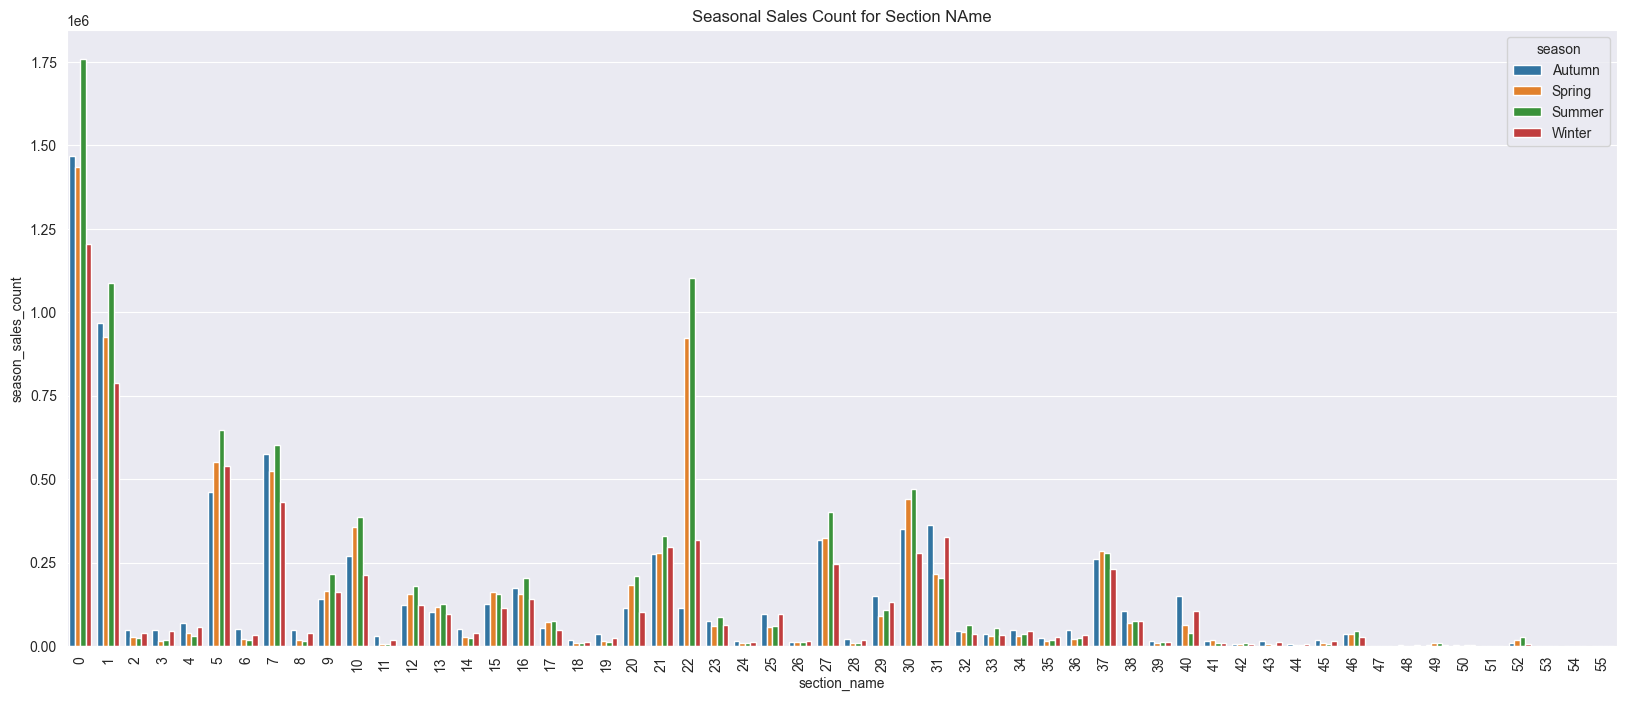

In [34]:
data = transactions_articles.groupby(["season", "section_name"])["article_id"].count().reset_index(name="season_sales_count")
plt.figure(figsize=(20, 8))
sns.barplot(x="section_name", y='season_sales_count', hue='season', data=data)
plt.xticks(rotation=90)
plt.title('Seasonal Sales Count for Section NAme')
plt.show()

Disclaimer (see below): not every difference between seasons in this kind of plot is meaningful. This is because it just counts the amount of sales per feature for each season but the amount of transactions are different between seasons. Of course, more transactions also increases the sales per feature even though the relative popularity doesn't change.

In [35]:
temp = transactions_train.groupby(["season"])["article_id"].count().reset_index(name="transactions")
temp

,season,transactions
0,Autumn,7632687
1,Spring,8073972
2,Summer,9320427
3,Winter,6761238


In [36]:
# relative size of current season compared to all periods
current_period_transactions = len(transactions_train[transactions_train["season"] == current_season])
all_transactions = len(transactions_train)
relative_size = current_period_transactions / all_transactions

#### Identifying seasonal preferences
Checking whether articles with a particular feature have significantly higher sales in a particular season

In [37]:
all_scores = {}
features = ["prod_name", "product_type_name", "product_group_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"]

In [38]:
for feature in features:
    print(feature)
    # Grouping by season and product type name and counting the number of sales
    seasonal_sales_by_type = transactions_articles.groupby(["season", feature])["article_id"].count().reset_index(name="season_sales_count")
    assert seasonal_sales_by_type["season_sales_count"].sum() == len(transactions_train)


    # plt.figure(figsize=(20, 8))
    # sns.barplot(x=feature, y='season_sales_count', hue='season', data=seasonal_sales_by_type)
    # plt.xticks(rotation=90)
    # plt.title('Seasonal Sales Count for Each Colour Group')
    # plt.show()
    
    # Calculating the average sale of a type across seasons and then removing the other periods
    type_average_sales = seasonal_sales_by_type.groupby(feature)["season_sales_count"].sum().div(1/relative_size).reset_index(name="average_all_seasons")
    seasonal_sales_by_type = seasonal_sales_by_type[seasonal_sales_by_type["season"] == current_season]
    seasonal_sales_by_type = seasonal_sales_by_type.merge(type_average_sales, on=feature)
    
    # Calculating the ratio of how much the feature is sold more in the current period than in other periods
    seasonal_sales_by_type["season_ratio"] = seasonal_sales_by_type["season_sales_count"] / seasonal_sales_by_type["average_all_seasons"]
    
    # #Make it binary
    # seasonal_sales_by_type["season_ratio"] = seasonal_sales_by_type["season_ratio"].apply(lambda x: 1 if x >= 1 else 0)
    
    # Only keeping the 75% most sold combinations
    threshold = seasonal_sales_by_type["season_sales_count"].quantile(0.25)
    seasonal_sales_by_type = seasonal_sales_by_type[seasonal_sales_by_type["season_sales_count"] > threshold]
 
    # Keeping the relevant columns
    seasonal_sales_by_type = seasonal_sales_by_type[[feature, "season_ratio"]]
    seasonal_sales_by_type = seasonal_sales_by_type.rename(columns={feature:"type"})
    all_scores[feature] = seasonal_sales_by_type

prod_name
product_type_name
product_group_name
graphical_appearance_name
colour_group_name
perceived_colour_value_name
perceived_colour_master_name
department_name
index_name
index_group_name
section_name
garment_group_name


In [39]:
all_scores["prod_name"]

,type,season_ratio
0,0,0.444774
1,1,0.380846
2,2,0.370387
3,3,0.657020
4,4,2.490678
...,...,...
39410,45865,1.388254
39412,45867,2.165676
39413,45868,0.734958
39414,45869,1.917113


In [40]:
def create_article_season_score(article):
    season_score = 0
    for feature in features:
        # Find the same feature value as the article in the right table
        score_table = all_scores[feature]
        feature_value = article[feature]
        # print(f"Zoeken naar: {feature_value}")
        x = score_table.loc[score_table["type"] == feature_value, "season_ratio"]
        assert 0 <= len(x) <= 1
        if len(x) == 1:
            season_score += x.iloc[0]
    return season_score

articles["current_season_score"] = articles.apply(create_article_season_score, axis=1) # apply row by row
articles["current_season_score2"] = MinMaxScaler().fit_transform(articles[["current_season_score"]]) # scale between 0 and 1

In [41]:
articles

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,current_season_score,current_season_score2
0,108775015,108775,12855,253,9,0,1010016,0,9,0,...,0,1,0,16,30,1002,2,8834,12.218658,0.558283
1,108775044,108775,12855,253,9,0,1010016,0,10,2,...,0,1,0,16,30,1002,2,8834,10.892761,0.487550
2,108775051,108775,44846,253,9,0,1010017,3,11,11,...,0,1,0,16,30,1002,2,8834,13.779226,0.641535
3,110065001,110065,8159,306,13,4,1010016,0,9,0,...,7,1,0,61,5,1017,4,8243,11.622086,0.526457
4,110065002,110065,8159,306,13,4,1010016,0,10,2,...,7,1,0,61,5,1017,4,8243,10.296189,0.455724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,953450001,953450,24043,302,14,7,1010014,6,9,0,...,2,3,3,26,16,1021,13,28026,17.122570,0.819893
105538,953763001,953763,24027,253,9,0,1010016,0,9,0,...,0,1,0,2,15,1005,0,28025,14.988446,0.706043
105539,956217002,956217,24040,265,1,2,1010016,0,9,0,...,0,1,0,18,12,1005,0,28024,14.575634,0.684021
105540,957375001,957375,24041,72,48,3,1010016,0,9,0,...,1,2,2,52,25,1019,1,28023,11.846853,0.538448


In [42]:
articles.to_parquet(path + 'articles_edited.parquet')

# Training the radek model
The code below is based on the template of Noah Daniëls, but it was edited to also incorporate the autumn score together with the bestseller rank

#### Candidate generation

In [43]:
# ## EDITED THIS TEMPLATE FROM NOAH DANIELS
# def get_data(transactions, current_season_scores, test_week):
#     ### repurchase
#     # each week is seen as a basket
#     # the items bought in one basket, will be example for the next basket
#     # the items bought in the last basket, will be candidates for the test basket
#     c2weeks = transactions.groupby('customer_id')['week'].unique()
#     c2weeks2shifted_weeks = {}
#     for c_id, weeks in c2weeks.items():
#         c2weeks2shifted_weeks[c_id] = {}
#         for i in range(weeks.shape[0]-1):
#             c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i+1]
#         c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week
#     candidates_last_purchase = transactions.copy()
#     weeks = []
#     for i, (c_id, week) in enumerate(zip(transactions['customer_id'], transactions['week'])):
#         weeks.append(c2weeks2shifted_weeks[c_id][week])
#     candidates_last_purchase.week=weeks
#     
#     
#     
# 
#     # Count how many times each article was sold in each week and also add the corresponding season score
#     sales_counts = transactions.groupby(["week", "article_id"]).size().reset_index(name="count")
#     sales_counts = sales_counts.merge(current_season_scores, on="article_id").reset_index()
#     
#     # Old code
#     # sales_counts = transactions.merge(current_season_scores, on="article_id")
#     # sales_counts = sales_counts.groupby(['week', 'article_id', 'current_season_score']).size().reset_index(name='count')
#     
#     # The weighted sales combines the global popularity together with season score
#     sales_counts["weighted_sales"] = sales_counts["count"] ** sales_counts['current_season_score']
#     sales_counts["ranked_weighted_sales"] = (sales_counts.groupby("week")["weighted_sales"].rank(method="dense", ascending=False).astype("int64"))
#     
#     # Keep the 12 most popular items, add the mean price and shift the week by 1
#     sales_counts = sales_counts[sales_counts["ranked_weighted_sales"] <= 12]
#     sales_counts.week += 1
#     sales_counts = sales_counts.sort_values(by=["week", "article_id"])
#     
#     unique_transactions = transactions.groupby(['week', 'customer_id']).head(1).drop(columns=['article_id', 'price']).drop_duplicates(["week","customer_id"]).copy()
#     candidates_bestsellers = pd.merge(unique_transactions,sales_counts,on='week')
#     test_set_transactions = unique_transactions.drop_duplicates('customer_id').reset_index(drop=True)
#     test_set_transactions.week = test_week
#     candidates_bestsellers_test_week = pd.merge(test_set_transactions,sales_counts,on='week')
#     candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])
#     candidates_bestsellers.drop(columns='ranked_weighted_sales', inplace=True)
#     
# 
#     ### combine
#     d = transactions.copy()
#     d['purchased'] = True
# 
#     result = pd.concat([
#         d, candidates_last_purchase, candidates_bestsellers
#     ])
#     result.purchased.fillna(False, inplace=True)
#     result.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)
# 
#     result = pd.merge(
#         result,
#         sales_counts[['week', 'article_id', 'ranked_weighted_sales']],
#         on=['week', 'article_id'],
#         how='left'
#     )
#     result = result[result.week != result.week.min()]
#     result["ranked_weighted_sales"].fillna(999, inplace=True)
# 
#     result.sort_values(['week', 'customer_id'], inplace=True)
#     result.reset_index(drop=True, inplace=True)
#     return result

#### Helper functions

In [44]:
def add_features(data):
    columns_to_use = [
        'article_id',
        'product_type_no',
        'graphical_appearance_no',
        'colour_group_code',
        'perceived_colour_value_id',
        'perceived_colour_master_id',
        'department_no',
        'index_code',
        'index_group_no',
        'section_no',
        'garment_group_no',
        'FN',
        'Active',
        'club_member_status',
        'fashion_news_frequency',
        'age',
        'postal_code',
        'ranked_weighted_sales'
    ]

    result = data
    result = pd.merge(result, customers, how='left', on='customer_id')
    result = pd.merge(result, articles, how='left', on='article_id')

    # features from assignment 2 could go here
    # customer_avg_price = transactions_train.groupby('customer_id')['price'].mean().to_frame('preferred_price')
    # result = pd.merge(result, customer_avg_price, how="left", on="customer_id")

    return result[columns_to_use]

    

In [45]:
def recall(predictions, purchases, k=12):
    # number of correct predictions for the customer / items bought by the customer
    # total recall is the average recall over all customers
    
    def row_recall(row):
        assert 0 < len(row.purchases)
        correct = 0
        for predicted_item in row.prediction[:k]:
            if predicted_item in row.purchases:
                correct += 1
        return correct / min(len(row.purchases), 12)

    result = pd.merge(purchases, predictions, on="customer_id", how="inner")
    result["recall"] = result.apply(row_recall, axis=1)

    return result.recall.sum() / len(purchases)

#### Training the ranker


In [58]:
### split into training and testing
# one week is used for testing
# a number of weeks leading up to the test week are used to train the ranker
test_week = 105
num_training_weeks = 10
training_weeks = np.arange(test_week-num_training_weeks, test_week)
train_data = transactions_train[transactions_train.week.isin(training_weeks)].reset_index(drop=True)
current_season_scores = articles[['article_id', 'current_season_score']].copy()

In [59]:
### repurchase
# each week is seen as a basket
# the items bought in one basket, will be example for the next basket
# the items bought in the last basket, will be candidates for the test basket
c2weeks = train_data.groupby('customer_id')['week'].unique()
c2weeks2shifted_weeks = {}
for c_id, weeks in c2weeks.items():
    c2weeks2shifted_weeks[c_id] = {}
    for i in range(weeks.shape[0]-1):
        c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i+1]
    c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week
candidates_last_purchase = train_data.copy()
weeks = []
for i, (c_id, week) in enumerate(zip(train_data['customer_id'], train_data['week'])):
    weeks.append(c2weeks2shifted_weeks[c_id][week])
candidates_last_purchase.week=weeks


In [60]:
# Count how many times each article was sold in each week and also add the corresponding season score
sales_counts = train_data.groupby(["week", "article_id"]).size().reset_index(name="count")
sales_counts = sales_counts.merge(current_season_scores, on="article_id").reset_index()

# Old code
# sales_counts = transactions.merge(current_season_scores, on="article_id")
# sales_counts = sales_counts.groupby(['week', 'article_id', 'current_season_score']).size().reset_index(name='count')

# The weighted sales combines the global popularity together with season score
sales_counts["weighted_sales"] = sales_counts["count"] ** sales_counts['current_season_score']
sales_counts["ranked_weighted_sales"] = (sales_counts.groupby("week")["weighted_sales"].rank(method="dense", ascending=False).astype("int64"))

# Keep the 12 most popular items, add the mean price and shift the week by 1
sales_counts = sales_counts[sales_counts["ranked_weighted_sales"] <= 12]
sales_counts.week += 1
sales_counts = sales_counts.sort_values(by=["week", "article_id"])

# A list of all customers that bought something during each week
customers_per_week = (train_data.groupby(['week', 'customer_id']).head(1).
                       drop(columns=['article_id', 'price', "t_dat", "season", "sales_channel_id"]).drop_duplicates(["week","customer_id"]).copy())
customers_per_week

,customer_id,week
0,272412481300040,95
5,1456826891333599,95
7,2133687643102426,95
8,6010692573790711,95
14,6171059100114610,95
...,...,...
2762860,18435221511488011015,104
2762862,18436859303155335645,104
2762864,18437941771381362708,104
2762866,18438270306572912089,104


In [61]:
# sales count range is week 96-105, customers per week range is week 95-104
# bestsellers per week, combined with all customers that bought something during that week (range becomes week 96-104)
candidates_bestsellers = pd.merge(customers_per_week,sales_counts,on='week')

In [62]:
# bestsellers of week 105, combined with all customers who ever bought something
candidates_bestsellers_test_week = customers_per_week.drop_duplicates('customer_id').reset_index(drop=True) # all customers who ever bought something
candidates_bestsellers_test_week.week = test_week # join on test week
candidates_bestsellers_test_week = pd.merge(candidates_bestsellers_test_week,sales_counts,on='week')

In [63]:
# Combine bestsellers of week 96-104 with bestsellers of week 105
candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])

In [64]:
candidates_bestsellers.drop(columns='ranked_weighted_sales', inplace=True)

In [65]:
### combine
d = train_data.copy()
d['purchased'] = True

candidates = pd.concat([
    d, candidates_last_purchase, candidates_bestsellers
])
candidates.purchased.fillna(False, inplace=True)
candidates.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

candidates = pd.merge(
    candidates,
    sales_counts[['week', 'article_id', 'ranked_weighted_sales']],
    on=['week', 'article_id'],
    how='left'
)
candidates = candidates[candidates.week != candidates.week.min()]
candidates["ranked_weighted_sales"].fillna(999, inplace=True)

candidates.sort_values(['week', 'customer_id'], inplace=True)
candidates.reset_index(drop=True, inplace=True)

In [66]:
### assemble training data (positive + negative examples)
# each example has at least a customer_id, article_id and whether it was purchased or not (positive/negative)
# add_features extracts and adds features to the examples
train_examples = candidates[candidates.week != test_week]

X_train = add_features(train_examples)
Y_train = train_examples['purchased']

### fit ranker
# training_groups tells LGBM that each (week, customer_id) combination is a seperate basket
# !!! it is important that the training_examples are sorted according to week, customer_id for this to work
ranker = LGBMRanker(
    force_row_wise=True,
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)
train_groups = train_examples.groupby(['week', 'customer_id'])['article_id'].count().values
ranker.fit(X_train, Y_train, group=train_groups)
print_importance(ranker, X_train.columns)

### test
# candidates are generated similarly to the examples, only we don't know whether they are purchased
# the same features are extracted and added
# each candidate is scored by the ranker and predictions are generated using the highest scoring candidates
test_candidates = candidates[candidates.week == test_week]

X_test = add_features(test_candidates)
predictions = get_predictions(test_candidates, X_test, ranker, 12)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.163841
[LightGBM] [Info] Total Bins 1075
[LightGBM] [Info] Number of data points in the train set: 11391444, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
         ranked_weighted_sales 0.99894
                           age 0.00023
                    article_id 0.00021
              garment_group_no 0.00011
               product_type_no 0.00011
    perceived_colour_master_id 0.00010
             colour_group_code 0.00008
                   postal_code 0.00007
            club_member_status 0.00007
                 department_no 0.00006
        fashion_news_frequency 0.00001
                        Active 0.00001
                            FN 0.00000
                    section_no 0.00000
                    index_code 0.00000
     perceived_colour_value_id 0.00000
       graphical_appearance_no 0.00000
                index_group_no 0.00000


In [67]:
predictions.head(1000)

,customer_id,prediction
0,28847241659200,"[925246001, 918522001, 915529003, 915529005, 9..."
1,41318098387474,"[868879003, 915529003, 915529005, 918522001, 9..."
2,116809474287335,"[906305002, 918522001, 915529003, 915529005, 9..."
3,200292573348128,"[903861001, 918522001, 915529003, 915529005, 9..."
4,248294615847351,"[720504008, 337991001, 878987003, 471714002, 9..."
...,...,...
995,42872089953753496,"[547780003, 884405006, 816423004, 915529003, 9..."
996,42878316430623896,"[875073002, 882810003, 866657002, 915529003, 9..."
997,42910407533866495,"[771693001, 912100001, 786336005, 915529003, 9..."
998,42942643248675808,"[827968001, 880575001, 918522001, 915529003, 9..."


In [68]:
print(len(predictions))

437365


In [69]:
### evaluate
if test_week < transactions_train.week.max() + 1:
    # get ground truth data for test week
    purchases = get_purchases(transactions_train[transactions_train.week == test_week])

    # fill missing prediction for customers in test set with popular items in last week
    # only for customers in test set because only those are evaluated
    popular = transactions_train[transactions_train.week == test_week-1].article_id.value_counts().head(12).index.values
    predictions = fill_missing_predictions(predictions, purchases.customer_id, popular)

    # calculate score
    score = mean_average_precision(predictions, purchases, 12)
    print(score)
    score2 = recall(predictions, purchases, 12)
    print(score2)

### submit
else:
    # fill missing predictions for all customers with popular items in last week
    # all customers because we don't know which ones will be evaluated
    popular = transactions_train[transactions_train.week == test_week-1].article_id.value_counts().head(12).index.values
    predictions = fill_missing_predictions(predictions, customers.customer_id, popular)

    # write submission
    sub = create_submission(predictions, sample_submission)
    sub.to_csv(path + 'sub1.csv.gz', index=False)